# Task 1: Data Understanding \& Preparatio

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [3]:
import warnings 

warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../dataset/customer_supermarket.csv', sep='\t', index_col=0)
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,09/12/11 12:50,"2,1",12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,09/12/11 12:50,"4,15",12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,09/12/11 12:50,"4,15",12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,09/12/11 12:50,"4,95",12680.0,France,22138,BAKING SET 9 PIECE RETROSPOT,3


## Basic checks

In [6]:
n_samples = df.shape[0]
df.drop_duplicates(ignore_index=True, inplace=True)
duplicates = n_samples - df.shape[0]
print('Number of canceled duplicates: {}/{} ({:.2f}%)'.format(duplicates, n_samples, duplicates / n_samples * 100))

Number of canceled duplicates: 5232/471910 (1.11%)


In [7]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

In [8]:
df['Sale'] = df['Sale'].str.replace(',', '.')
df['Sale'] = pd.to_numeric(df['Sale'])
df = df.astype({'BasketDate': 'datetime64',
                'CustomerID': 'object'})

In [9]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

## Number of relevant objects

In [10]:
pd.DataFrame([{'transactions': df['BasketID'].nunique(), 
               'customers': df['CustomerID'].nunique(), 
               'products': df['ProdID'].nunique()}], index=['quantity'])

,transactions,customers,products
quantity,24627,4372,3953


## Check for null values

In [11]:
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

In [12]:
n_samples = df.shape[0]
null_customers = df['CustomerID'].isnull().sum()
print('Number of null CustomerID(s): {}/{} ({:.2f}%)'.format(null_customers, n_samples, null_customers / n_samples * 100))
null_prod_descrs = df['ProdDescr'].isnull().sum()
print('Number of null ProdDescr(s): {}/{} ({:.2f}%)'.format(null_prod_descrs, n_samples, null_prod_descrs / n_samples * 100))

Number of null CustomerID(s): 65073/466678 (13.94%)
Number of null ProdDescr(s): 753/466678 (0.16%)


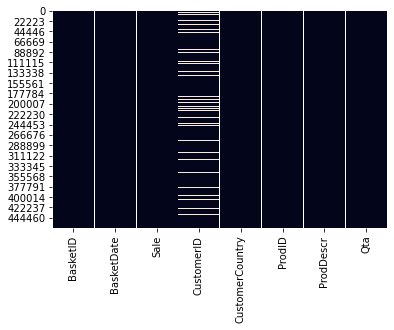

In [13]:
sns.heatmap(df.isnull(), cbar=False);

## Observation
* Only *CustomerID* and *ProdDescr* have null values
* *CustomerID* has ~65000 null values
* *ProdDescr* has 753 null values

## Numerical attribute statitics

In [14]:
df.describe()

,Sale,Qta
count,466678.000000,466678.000000
mean,4.049057,10.806528
std,84.237135,232.627771
min,-11062.060000,-80995.000000
25%,1.250000,2.000000
50%,2.080000,4.000000
75%,3.750000,12.000000
max,38970.000000,80995.000000


## Observation
* Both *Sale* and *Qta* have negative values, is that correct?
* Both *Sale* and *Qta* have large positive and negative values, are those errors?

## General observation
*  **BasketID**:
    *  ***Observations***:
        * it appears to be a six digit code.
        * it has no null value.
* **BasketDate**:
    * ***Observations***:
        * it indicates the date of the Baskets.
        * BasketDates corresponding to the same BasketsID have the same values.
* **Sale**:
    * ***Observations***:
        * indicates the unit price of an item.
        * it has a large (~11000) negative value.
        * it has a large (~38000) positive value.
        * it has no null values.
* **Customer**:
    * ***Observations***:
        * the customer is a six digit code
        * the attribute has null values
* **ProdID**
    * ***Observations***:
        * it is mainly represented as a five digit code followed by a variable number of characters (2-3)
        * it also have particulars values (i.e. *M*, *D*, *AMAZONFEE*, ecc...)
* **Qta**:
    * ***Observations***:
        * indicates the quantity of a purchase
        * it has both positive and negative values
        * it has both large positive and large negative values
        * the min (largest negative) correspond to the max (largest positive) in absolute values
* **ProdDescr**:
    * ***Observations***:
        * it has null values

### BasketID
Define a "good BasketID" as a six digit code. Every other BasketID which isn't a six digit code is a "bad BasketID"

In [15]:
def good_bid(val):
    # Returns True is val is a good BasketID (i.e. six digit code), else False
    if len(val) == 6:
        if val.isnumeric():
            return True
    return False

In [39]:
n_samples = df.shape[0]
n_baskets = df['BasketID'].nunique()
gbid = df[df['BasketID'].apply(good_bid)]
bbid = df[~df['BasketID'].apply(good_bid)]

print('There are {} ({:.2f}%) records with good BasketID and {} ({:.3f}%) records with bad BasketID'.format(
         gbid.shape[0], gbid.shape[0]/n_samples*100,
         bbid.shape[0], bbid.shape[0]/n_samples*100) )

print('There are {} ({:.2f}%) records with good BasketID and {} ({:.3f}%) records with bad BasketID'.format(
         gbid['BasketID'].nunique(), gbid['BasketID'].nunique()/n_baskets*100,
         bbid['BasketID'].nunique(), bbid['BasketID'].nunique()/n_baskets*100))

There are 457625 (98.06%) records with good BasketID and 9053 (1.940%) records with bad BasketID
There are 20871 (84.75%) records with good BasketID and 3756 (15.252%) records with bad BasketID
There are 20871 good baskets and 3756 bad baskets


In [42]:
bbid

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24
...,...,...,...,...,...,...,...,...
465754,C581490,2011-09-12 09:57:00,0.83,14397,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11
466316,C581499,2011-09-12 10:28:00,224.69,15498,United Kingdom,M,Manual,-1
466483,C581568,2011-09-12 11:57:00,10.95,15311,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5
466484,C581569,2011-09-12 11:58:00,1.25,17315,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1


In [44]:
bbid['BasketID'].apply(lambda x: x[0]).unique()

array(['C', 'A'], dtype=object)

All the *bad* BasketID starts either with *C* or *A*

In [49]:
print('Bad BasketID starting with C:', bbid['BasketID'].apply(lambda x: 1 if x[0] == 'C' else 0).sum())
print('Bad BasketID starting with A:', bbid['BasketID'].apply(lambda x: 1 if x[0] == 'A' else 0).sum())

Bad BasketID starting with C: 9051
Bad BasketID starting with A: 2


In [54]:
c_bbid = bbid[bbid['BasketID'].apply(lambda x: True if x[0] == 'C' else False)]
c_bbid.describe()

,Sale,Qta
count,9051.000000,9051.000000
mean,33.007078,-30.305270
std,553.867971,1160.605782
min,0.010000,-80995.000000
25%,1.450000,-6.000000
50%,2.950000,-2.000000
75%,5.415000,-1.000000
max,38970.000000,-1.000000


In [55]:
c_bbid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9051 entries, 141 to 466485
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BasketID         9051 non-null   object        
 1   BasketDate       9051 non-null   datetime64[ns]
 2   Sale             9051 non-null   float64       
 3   CustomerID       8872 non-null   object        
 4   CustomerCountry  9051 non-null   object        
 5   ProdID           9051 non-null   object        
 6   ProdDescr        9051 non-null   object        
 7   Qta              9051 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 636.4+ KB


All the BasketIDs starting with *C* have a negative quantity, *C* may indicate that a BasketID a *refound* or a *cancellation*.

In [56]:
a_bbid = bbid[bbid['BasketID'].apply(lambda x: True if x[0] == 'A' else False)]
a_bbid.describe()

,Sale,Qta
count,2.00,2.0
mean,-11062.06,1.0
std,0.00,0.0
min,-11062.06,1.0
25%,-11062.06,1.0
50%,-11062.06,1.0
75%,-11062.06,1.0
max,-11062.06,1.0


In [58]:
a_bbid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 254213 to 254214
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BasketID         2 non-null      object        
 1   BasketDate       2 non-null      datetime64[ns]
 2   Sale             2 non-null      float64       
 3   CustomerID       0 non-null      object        
 4   CustomerCountry  2 non-null      object        
 5   ProdID           2 non-null      object        
 6   ProdDescr        2 non-null      object        
 7   Qta              2 non-null      int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 144.0+ bytes


All the BasketIDs starting with *A* have a negative sale and null CustomerID.

There are no bad BasketID with wither negative sale and negative quantities.

Does the opposite of the following rules holds? All the rows with negative quantities start with *C*? All the rows with negative sale start with *A*?

In other words: 
* Exist some record with negative Qta and good BasketID? (yes)
* Exist some record with negative Qta and good BasketID? (no)

In [73]:
print(gbid[gbid['Qta'] < 0].shape[0])
print(gbid[gbid['Sale'] < 0].shape[0])

668
0


In [74]:
gbid[gbid['Qta'] < 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 3677 to 461914
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BasketID         668 non-null    object        
 1   BasketDate       668 non-null    datetime64[ns]
 2   Sale             668 non-null    float64       
 3   CustomerID       0 non-null      object        
 4   CustomerCountry  668 non-null    object        
 5   ProdID           668 non-null    object        
 6   ProdDescr        221 non-null    object        
 7   Qta              668 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 47.0+ KB


There are some rows with good BasketID and negative quantities, moreover those rows have a null CustomerID and most of them a null ProdDescr.

### CustomerID

Since the aim is to produce a customer segmentation, we are going to remove the entries for which the *CustomerID* variable is null.

In [75]:
df = df[~df['CustomerID'].isnull()]
df.reset_index(drop=True, inplace=True)
df['CustomerID'].isnull().any()

False

By deleting all the null customer we also deleted all the rows with BasketID starting with *A* and all the rows with good BasketID and negative Qta.

The resulting datasate has:
* No negative Sale
* All the bad BasketID starts with *C*
* All the negative quantities have a bad BasketID 

### Product IDs

The ProdID seems to be a five digit code, eventually followed by some letters. There are also ProdID which don't satisfy this constraint.

In [76]:
special_codes = df[df['ProdID'].str.contains('^[a-zA-Z]+', regex=True)]['ProdID'].unique()
for code in special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['ProdID'] == code]['ProdDescr'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


In [88]:
def good_pid(val):
    if len(val) >= 5:
        if val[0:5].isnumeric():
            return True
    return False

special_codes = df[~df['ProdID'].apply(good_pid)]['ProdID'].unique()
for code in special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['ProdID'] == code]['ProdDescr'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


In [89]:
df = df[~df.ProdID.isin(special_codes)]
df.reset_index(drop=True, inplace=True)
df.ProdID.isin(special_codes).any()

False

# NOTA! entrambe le procedure riportano lo stesso risultato, scegliere una tra le due.
(personalmente la seconda mi sembra più chiara, l'ho inclusa per questo ma volevo anche un altro parare)

### Qta

Then, we examined the existence of entries with the prefix *C* for the *BasketID* variable which indicates transactions that have been canceled since for each of those correspond a negative quantity.

In [90]:
canceled_orders = df[df['BasketID'].str.contains('C')]
canceled_orders

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
152,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
233,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
234,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
235,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21980,PACK OF 12 RED RETROSPOT TISSUES,-24
...,...,...,...,...,...,...,...,...
399249,C581490,2011-09-12 09:57:00,1.95,14397,United Kingdom,22178,VICTORIAN GLASS HANGING T-LIGHT,-12
399250,C581490,2011-09-12 09:57:00,0.83,14397,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11
399498,C581568,2011-09-12 11:57:00,10.95,15311,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5
399499,C581569,2011-09-12 11:58:00,1.25,17315,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1


In [91]:
(canceled_orders['Qta'] < 0).all()

True

We decide to create a new variable in the dataframe that indicate if part of the order has been canceled.

In [92]:
df['QtaCanc'] = 0

For the cancellations without counterparts, they are probably due to the fact that the buy orders were placed before December 2010, the point of entry of the dataset. Below, we make a census of the cancel orders and check for the existence of counterparts:

In [93]:
counterpart_entries = []
no_counterpart_entries = []

for index, col in canceled_orders.iterrows():
        
    df_test = df[(df['CustomerID'] == col['CustomerID']) & 
                 (df['ProdID'] == col['ProdID']) & 
                 (df['BasketDate'] <= col['BasketDate']) & 
                 (df['Qta'] > 0)].copy()
    
    # cancelation without a counterpart
    if df_test.shape[0] == 0:
        no_counterpart_entries.append(index)
    
    # cancelation with a counterpart
    elif df_test.shape[0] == 1:
        index_order = df_test.index[0]
        df.loc[index_order, 'QtaCanc'] = -col['Qta']
        counterpart_entries.append(index)
    
    # multiple counterparts exist: we delete the most recent
    elif df_test.shape[0] > 1:
        df_test.sort_index(ascending=False, inplace=True)
        for idx, val in df_test.iterrows():
            if val['Qta'] < -col['Qta']: 
                continue
            df.loc[idx, 'QtaCanc'] = -col['Qta']
            counterpart_entries.append(index) 
            break

In [94]:
n_canceled = canceled_orders.shape[0]
print('Number of canceled orders with a counterpart: {}/{} ({:.2f}%)'.format(
    len(counterpart_entries), n_canceled, len(counterpart_entries) / n_canceled * 100))
print('Number of canceled orders without a counterpart: {}/{} ({:.2f}%)'.format(
    len(no_counterpart_entries), n_canceled, len(no_counterpart_entries) / n_canceled * 100))

df.drop(counterpart_entries, inplace=True)
df.drop(no_counterpart_entries, inplace=True)
df.reset_index(drop=True, inplace=True)

remaining_canceled = df[df['Qta'] < 0].shape[0]
print('Number of remaining canceled orders (with counterpart orders probably placed before December 2010): {}/{} ({:.2f}%)'.format(
    remaining_canceled, n_canceled, remaining_canceled / n_canceled * 100))

Number of canceled orders with a counterpart: 6109/8506 (71.82%)
Number of canceled orders without a counterpart: 2358/8506 (27.72%)
Number of remaining canceled orders (with counterpart orders probably placed before December 2010): 39/8506 (0.46%)


In [95]:
df['Qta'] = df['Qta'] - df['QtaCanc']
df.drop('QtaCanc', axis=1, inplace=True)

In [96]:
df = df[df['Qta'] > 0]
df.reset_index(drop=True, inplace=True)
(df['Qta'] < 0).any()

False

### Customers Country

In [97]:
countries = df['CustomerCountry'].value_counts()
countries

United Kingdom          347171
Germany                   8606
France                    7972
EIRE                      7015
Spain                     2400
Netherlands               2322
Belgium                   1931
Switzerland               1808
Portugal                  1411
Australia                 1128
Norway                    1042
Channel Islands            743
Italy                      736
Finland                    647
Cyprus                     600
Sweden                     425
Austria                    384
Denmark                    365
Poland                     325
Japan                      320
Israel                     245
Unspecified                241
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      108
USA                         67
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

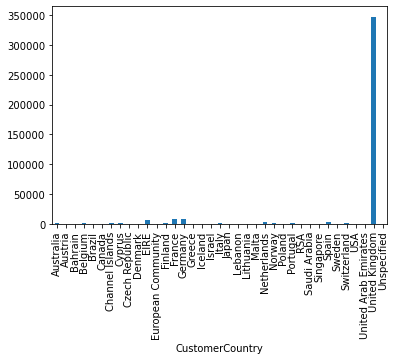

In [98]:
df['CustomerCountry'].groupby(df['CustomerCountry']).count().plot(kind='bar');

fig = go.Figure(
    data=go.Choropleth(
        locations=countries.index,
        z=np.log10(countries), 
        locationmode='country names', 
        colorscale='viridis',
        colorbar_title='LogOrderNb'))
fig.update_layout(title_text='Number of Orders per Country')

fig.show()
### Non ho il package

In [100]:
df.drop('CustomerCountry', axis=1, inplace=True)

### Baskets Date

We noticed that 2010 data aren't enough representative, they are only a small fraction of the dataset and they appear to be only around the 12th of the month; in contrast 2011's data are more uniformely distributed, so we decide to keep only the latter:

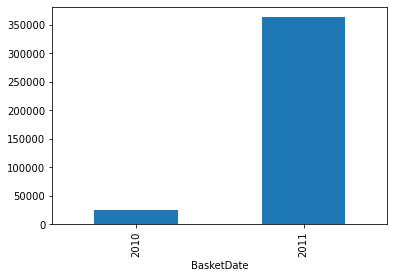

In [101]:
df['BasketDate'].groupby(df['BasketDate'].dt.year).count().plot(kind='bar');

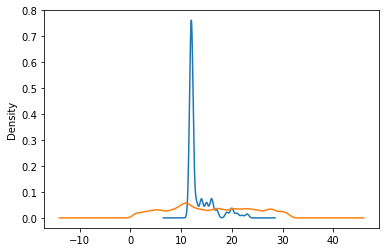

In [102]:
fig, ax = plt.subplots(1,1)
df[df['BasketDate'].dt.year == 2010]['BasketDate'].dt.day.plot(kind='kde', ax=ax);
df[df['BasketDate'].dt.year == 2011]['BasketDate'].dt.day.plot(kind='kde', ax=ax);

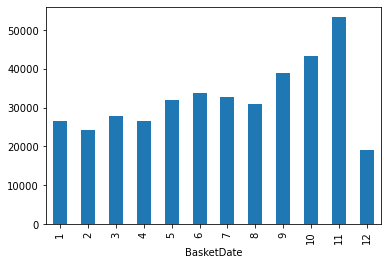

In [103]:
df['BasketDate'].groupby(df['BasketDate'].dt.month).count().plot(kind='bar');

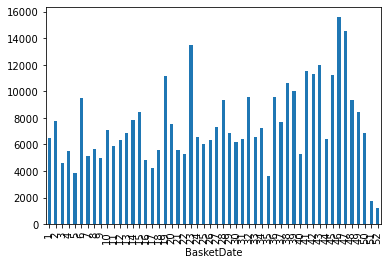

In [104]:
df['BasketDate'].groupby(df['BasketDate'].dt.week).count().plot(kind='bar');

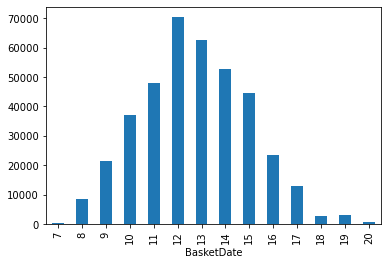

In [105]:
df['BasketDate'].groupby(df['BasketDate'].dt.hour).count().plot(kind='bar');

In [106]:
df = df[df['BasketDate'].dt.year == 2011]
df.reset_index(drop=True, inplace=True)
(df['BasketDate'].dt.year == 2010).any()

False

### Sales

In [107]:
df[df['Sale'] == 0]

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta
2870,540372,2011-06-01 16:41:00,0.0,13081,22090,PAPER BUNTING RETROSPOT,24
2872,540372,2011-06-01 16:41:00,0.0,13081,22553,PLASTERS IN TIN SKULLS,24
27038,543599,2011-10-02 13:08:00,0.0,17560,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16
58261,547417,2011-03-23 10:25:00,0.0,13239,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36
65253,548318,2011-03-30 12:45:00,0.0,13113,22055,MINI CAKE STAND HANGING STRAWBERY,5
69680,548871,2011-04-04 14:42:00,0.0,14410,22162,HEART GARLAND RUSTIC PADDED,2
79303,550188,2011-04-14 18:57:00,0.0,12457,22636,CHILDS BREAKFAST SET CIRCUS PARADE,1
100358,553000,2011-12-05 15:21:00,0.0,17667,47566,PARTY BUNTING,4
108708,554037,2011-05-20 14:13:00,0.0,12415,22619,SET OF 6 SOLDIER SKITTLES,80
165091,561284,2011-07-26 12:24:00,0.0,16818,22167,OVAL WALL MIRROR DIAMANTE,1


In [108]:
df['Sale'].replace(0, np.nan, inplace=True)
df['Sale'] = df.groupby('ProdID')['Sale'].transform(lambda x: x.replace(to_replace=np.nan, value=x.mean()))
df['Sale'].isnull().any()

False

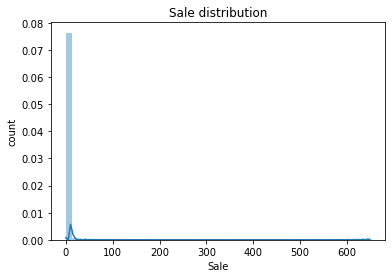

In [109]:
sns.distplot(df['Sale'])
plt.title('Sale distribution')
plt.xlabel('Sale')
plt.ylabel('count');

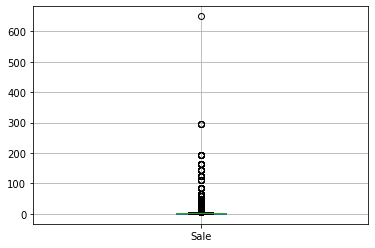

In [110]:
df.boxplot('Sale');

We can use the interquartile range method to reduce the outliers and distribution skewness:

- IQR = Q3 - Q1
- lower bound = Q1 - 1.5 * IQR
- upper bound = Q3 + 1.5 * IQR

### Products Description

In [111]:
df['ProdDescr'].isnull().any()

False

Now we need to remove the entries corresponding to lower or mixed case *ProdDescr* variable which will be not effective for the feature extraction step since they don't represent a product description:

In [112]:
df[(df['ProdDescr'].str.islower()) | # lower case
   (~df['ProdDescr'].str.islower() & ~df['ProdDescr'].str.isupper())]['ProdDescr'].unique() # mixed case

array(['BAG 125g SWIRLY MARBLES', 'BAG 500g SWIRLY MARBLES',
       '3 TRADITIONAl BISCUIT CUTTERS  SET',
       'FRENCH BLUE METAL DOOR SIGN No', 'NUMBER TILE VINTAGE FONT No ',
       'BAG 250g SWIRLY MARBLES', 'POLYESTER FILLER PAD 40x40cm',
       'POLYESTER FILLER PAD 45x45cm', 'FOLK ART GREETING CARD,pack/12',
       'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
       'POLYESTER FILLER PAD 45x30cm', 'POLYESTER FILLER PAD 30CMx30CM',
       'NUMBER TILE COTTAGE GARDEN No', 'POLYESTER FILLER PAD 65CMx65CM',
       'POLYESTER FILLER PAD 60x40cm', 'FLOWERS HANDBAG blue and orange',
       'Next Day Carriage', 'THE KING GIFT BAG 25x24x12cm',
       'High Resolution Image'], dtype=object)

In [113]:
df['ProdDescr'] = df['ProdDescr'].str.replace('[^\w\s]', '') # removing non-word chars (+, -, /, etc.) but leaving spaces
df['ProdDescr'] = df['ProdDescr'].str.replace('[0-9]+[a-zA-Z]*', '') # removing words containing numbers

df['ProdDescr'] = df['ProdDescr'].apply(lambda descr: ' '.join(descr.split())) # removing multiple whitespaces

# adjusting specific errors
df['ProdDescr'] = df['ProdDescr'].str.replace('No', '') # removing 'No'
df['ProdDescr'].replace({'TRADITIONAl BISCUIT CUTTERS SET': 'TRADITIONAl BISCUIT CUTTERS SET'.upper()}, inplace=True)
df['ProdDescr'].replace({'FLOWERS HANDBAG blue and orange': 'FLOWERS HANDBAG blue and orange'.upper()}, inplace=True)
df['ProdDescr'].replace({'FOLK ART GREETING CARDpack': 'FOLK ART GREETING CARD'}, inplace=True)

bad_descr = df[(df['ProdDescr'].str.islower()) | # lower case
               (~df['ProdDescr'].str.islower() & ~df['ProdDescr'].str.isupper())]['ProdDescr'].unique() # mixed case
bad_descr

array(['Next Day Carriage', 'High Resolution Image'], dtype=object)

In [114]:
df = df[~df['ProdDescr'].isin(bad_descr)]
df.reset_index(drop=True, inplace=True)
df['ProdDescr'].isin(bad_descr).any()

False

## Data Correlation

In [116]:
df['TotSale'] = df['Qta'] * df['Sale']

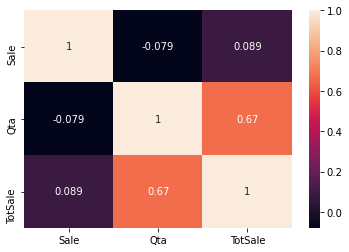

In [117]:
sns.heatmap(df.corr(), annot=True);

## Saving the new dataset

In [118]:
df.to_csv('../dataset/new_customer_supermarket.csv', sep='\t', float_format='%.2f')